# Processing of US Coastguard GPS disruption data

## Prerequisites

### Installs

In [1]:
%pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 7.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install lxml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 57.7 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


### Imports

In [1]:
import pandas as pd
from datetime import datetime as dt

In [2]:
from unidecode import unidecode


## Webscrape
Run this to webscrape the data to files. If you already have the data locally, skip this section.

### Web scrape GPS interruptions

In [3]:
table_list = pd.read_html(r'https://navcen.uscg.gov/gps-problem-report-status')
table_list[0].to_csv('gps_navcen.csv',index=False)

### Web scrape wikipedia 
#### US state codes

In [4]:
table_list_iso3166= pd.read_html('https://en.wikipedia.org/wiki/ISO_3166-2:US')

In [5]:
US_states_iso3166=table_list_iso3166[0]
US_states_iso3166['clean_state']=US_states_iso3166['Code'].apply(lambda x: x.split('-')[1])
US_states_iso3166.to_csv('US_states_iso3166.csv',index=False)

#### List of sovereign states

In [12]:
sovereign_states_list= pd.read_html('https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2')[4]

In [14]:
sovereign_states_list[sovereign_states_list['Country name (using title case)'].notna()].to_csv('sovereign_states.csv',index=False)

## Processing and Analysis

### Load from csv files

In [15]:
gps_disruption_df=pd.read_csv('gps_navcen.csv')
two_letter_codes=pd.read_csv('US_states_iso3166.csv')
sovereign_states=pd.read_csv('sovereign_states.csv')


In [16]:
gps_disruption_df['User']=gps_disruption_df['Description'].str.split(pat='NAVCEN',n=1,expand=True)[0]
gps_disruption_df['NAVCEN']=gps_disruption_df['Description'].str.split(pat='NAVCEN',n=1,expand=True)[1]

In [17]:
gps_disruption_df

,Disruption Date/Time,Location,Type,Description,Cause,Closed Date,User,NAVCEN
0,06/15/2023 15:55:00 Eastern African Time,JAZIRAT JABAL ZUQAR,Marine,USER: GPS Disruption Commenced at 1555 LT (125...,Unknown Interference,06/22/2023,USER: GPS Disruption Commenced at 1555 LT (125...,: The GPS Operations Center reviewed the GPS C...
1,06/02/2023 13:38:00 EST,"Sparta, Georgia",Automobile,"USER: On three separate devices, GPS was eithe...",Insufficient Information,06/22/2023,"USER: On three separate devices, GPS was eithe...",: The GPS Operations Center reviewed the GPS C...
2,05/25/2023 05:55:00 UTC,"Annapolis, MD",Other,USER: The tracking system on my boat sent an a...,Insufficient Information,06/22/2023,USER: The tracking system on my boat sent an a...,: The GPS Operations Center reviewed the GPS C...
3,05/22/2023 16:26:00 PST,"Perris, CA",Communications,USER: Google pin wanders off beyond GPS margin...,User Equipment,06/22/2023,USER: Google pin wanders off beyond GPS margin...,: There were no authorized GPS tests in the ar...
4,05/13/2023 23:30:31 EEST,"Constanta, Romania",Timing,"USER: We have often GPS outages, almost every ...",Unknown Interference,06/21/2023,"USER: We have often GPS outages, almost every ...",: The GPS Operations Center reviewed the GPS C...
...,...,...,...,...,...,...,...,...
454,01/05/2017 4:35 UTC,Chile,Law Enforcement,User: There were large spikes in geozone alarm...,User Equipment,05/20/2019,User: There were large spikes in geozone alarm...,: The GPS Operations Center reviewed the GPS C...
455,01/03/2017 11:AM CST,San Angelo Airport,Aviation,User: The GPS systems in normal mode not milit...,Unintentional Interference,05/20/2019,User: The GPS systems in normal mode not milit...,: Report referred to FCC. FCC conducted an inv...
456,01/02/2017 3:00 EST,North Carolina - South Carolina border,Transportation,User: GPS would say when you plug in that ther...,User Equipment,05/20/2019,User: GPS would say when you plug in that ther...,: The GPS Operations Center reviewed the GPS C...
457,01/01/2017 12:00 EST,"Elizabeth, NJ",Transportation,"User: My business is located in Elizabeth, NJ....",Mapping Issue,05/20/2019,"User: My business is located in Elizabeth, NJ....",: User provided information on how to contact ...


## Analyse disruptions by date

In [18]:
gps_disruption_df['local_date']=gps_disruption_df['Disruption Date/Time']\
.apply(lambda x:dt.strptime(x[0:10],'%m/%d/%Y'))

The local date is the UTC date with up to 0.5 day error. That's not bad for analysis to the nearest day. This will have to be improved for more precise analysis.

<Axes: xlabel='local_date'>

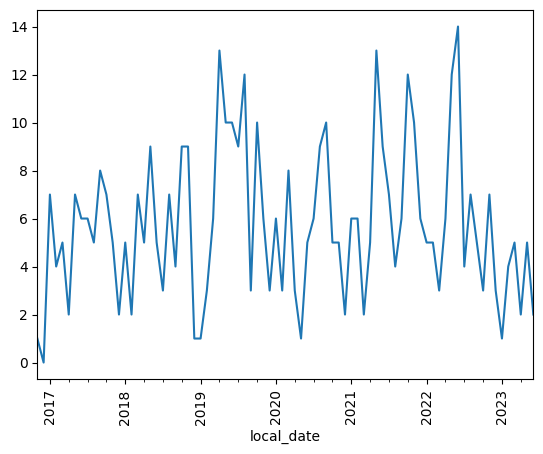

In [19]:
gps_disruption_df.resample('M', on='local_date').\
count()['Disruption Date/Time'].plot(rot=90)


## Analyse disruptions by location

### Add UK and US to two letter codes

In [20]:
two_letter_codes['code_spaced']=two_letter_codes['Code'].str.replace('-',' ')

In [21]:
two_letter_codes=\
pd.concat([two_letter_codes,\
           pd.DataFrame({'Code':"GB",'Subdivision name (en)':"United Kingdom",'Subdivision category':"Country",'clean_state':"UK",'code_spaced':"UK"},index=[two_letter_codes['Code'].count()])])
two_letter_codes=\
pd.concat([two_letter_codes,\
           pd.DataFrame({'Code':"US",'Subdivision name (en)':"United States",'Subdivision category':"Country",'clean_state':"US",'code_spaced':"US"},index=[two_letter_codes['Code'].count()])])

In [22]:
two_letter_codes

,Code,Subdivision name (en),Subdivision category,clean_state,code_spaced
0,US-AL,Alabama,State,AL,US AL
1,US-AK,Alaska,State,AK,US AK
2,US-AZ,Arizona,State,AZ,US AZ
3,US-AR,Arkansas,State,AR,US AR
4,US-CA,California,State,CA,US CA
5,US-CO,Colorado,State,CO,US CO
6,US-CT,Connecticut,State,CT,US CT
7,US-DE,Delaware,State,DE,US DE
8,US-FL,Florida,State,FL,US FL
9,US-GA,Georgia,State,GA,US GA


### Add previous and common names to ISO list

In [23]:
sovereign_states['previous country name']=\
sovereign_states['Notes']\
.str.split(pat='Previous ISO country name: ',n=1,expand=True)[1]\
.str.split(pat='(',n=1,expand=True)[0]\
.str.split(pat=';',n=1,expand=True)[0]\
.str.split(pat='.',n=1,expand=True)[0].str.strip()

#       if 'Previous ISO country name: ' in str(x) \
#       else None ) 


In [24]:
sovereign_states['common name']=\
sovereign_states['Notes']\
.str.split(pat='common name: ',n=1,expand=True)[1]\
.str.split(pat=')',n=1,expand=True)[0].str.strip()
       #if 'common name: ' in str(x) \
       #else None )

In [25]:
sovereign_states[sovereign_states['previous country name'].notna()]

,Code,Country name (using title case),Year,ccTLD,Notes,previous country name,common name
27,BN,Brunei Darussalam,1974,.bn,Previous ISO country name: Brunei,Brunei,None
28,BO,Bolivia (Plurinational State of),1974,.bo,Previous ISO country name: Bolivia,Bolivia,None
29,BQ,"Bonaire, Sint Eustatius and Saba",2010,.bq,"Consists of three Caribbean ""special municipal...","Bonaire, Saint Eustatius and Saba BQ previous...",None
46,CM,Cameroon,1974,.cm,"Previous ISO country name: Cameroon, United Re...","Cameroon, United Republic of",None
55,CZ,Czechia,1993,.cz,Previous ISO country name: Czech Republic,Czech Republic,None
65,EH,Western Sahara,1974,NaN,Previous ISO country name: Spanish Sahara (cod...,Spanish Sahara,None
72,FM,Micronesia (Federated States of),1986,.fm,Previous ISO country name: Micronesia,Micronesia,None
76,GB,United Kingdom of Great Britain and Northern I...,1974,.gb (.uk),Includes Akrotiri and Dhekelia (Sovereign Base...,United Kingdom,None
107,IR,Iran (Islamic Republic of),1974,.ir,Previous ISO country name: Iran,Iran,None
116,KH,Cambodia,1974,.kh,Code taken from former name: Khmer Republic P...,"Kampuchea, Democratic",None


In [26]:
sovereign_states[sovereign_states['common name'].notna()]

,Code,Country name (using title case),Year,ccTLD,Notes,previous country name,common name
71,FK,Falkland Islands (Malvinas),1974,.fk,ISO country name follows UN designation due to...,None,Falkland Islands
120,KP,Korea (Democratic People's Republic of),1974,.kp,ISO country name follows UN designation (commo...,None,North Korea
121,KR,"Korea, Republic of",1974,.kr,ISO country name follows UN designation (commo...,None,South Korea
190,RU,Russian Federation,1992,.ru,ISO country name follows UN designation (commo...,None,Russia
227,TW,"Taiwan, Province of China",1974,.tw,Covers the current jurisdiction of the Republi...,None,Taiwan
240,VN,Viet Nam,1974,.vn,ISO country name follows UN designation (commo...,None,Vietnam


### Clean up Location to get country/code 

In [51]:
gps_disruption_df['location_state_country']=(gps_disruption_df['Location'].str.upper()
 .str.split(pat=',',n=1,expand=True)[1].str.strip()
 .combine_first(
     gps_disruption_df['Location'].str.upper()
     .str.split(pat=',',n=1,expand=True)[0].str.strip()
 )
)

In [52]:
gps_disruption_df[['Location','location_state_country']]

,Location,location_state_country
0,JAZIRAT JABAL ZUQAR,JAZIRAT JABAL ZUQAR
1,"Sparta, Georgia",GEORGIA
2,"Annapolis, MD",MD
3,"Perris, CA",CA
4,"Constanta, Romania",ROMANIA
...,...,...
454,Chile,CHILE
455,San Angelo Airport,SAN ANGELO AIRPORT
456,North Carolina - South Carolina border,NORTH CAROLINA - SOUTH CAROLINA BORDER
457,"Elizabeth, NJ",NJ


<Axes: ylabel='location_state_country'>

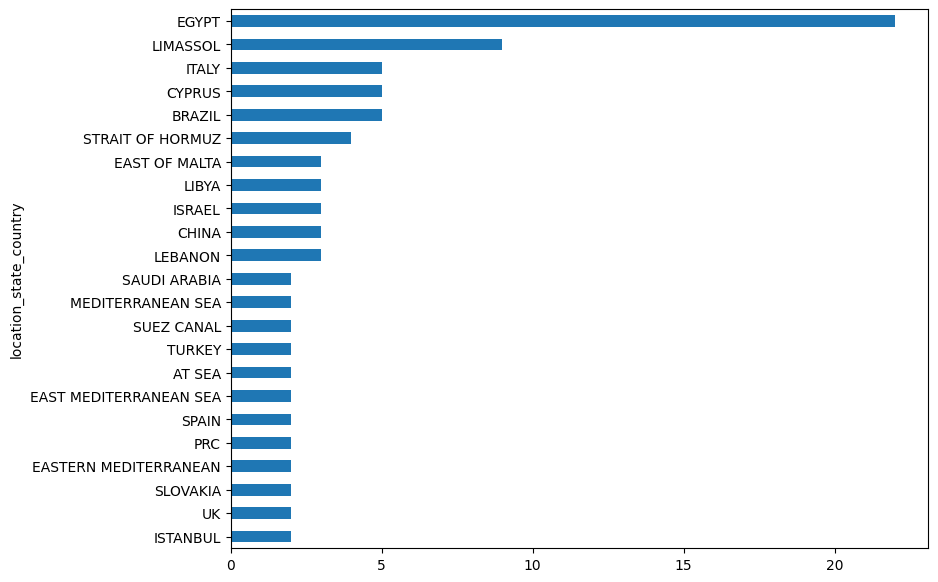

In [55]:
gps_disruption_counted=(gps_disruption_df[gps_disruption_df['location_state_country'].notna() & gps_disruption_df['Cause'].str.contains('Interference')]
                        .groupby('location_state_country')
                        .count()['Disruption Date/Time']
                        
                        .sort_values()
                       )
gps_disruption_counted[gps_disruption_counted>1].plot(kind='barh',figsize=[9,7])

US is still high in this list but the mediterranean countries form the other top cluster